### Imports

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.stats import probplot,t
import statsmodels.api as sm

%matplotlib inline

### Functions

In [2]:
def return_calculator(df,t):
    df["prev_close"] = df["close"].shift(t)
    df["return"] = df["close"]/df["prev_close"]-1
#     df["return2"] = df["close"].pct_change(t)
    df["log_return"] = np.log(df["return"]+1)
    return df


class myt:
    def __init__(self,df):
        self.df = df
        
    def fit(self,x):
        return t.fit(x)
    
    def ppf(self, x, loc=0, scale=1):
        return t.ppf(x, self.df, loc, scale)

### Read data

In [3]:
data = pd.read_csv("all_stocks_5yr.csv", parse_dates=True)

In [4]:
sbux = data[data["Name"]=="SBUX"].copy()

In [5]:
sbux.head()

,date,open,high,low,close,volume,Name
498152,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
498153,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
498154,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
498155,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
498156,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


1259


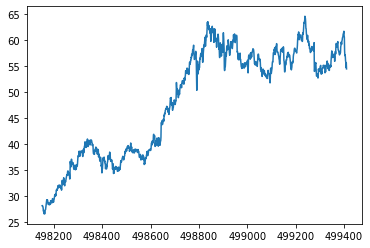

In [6]:
print(len(sbux))
sbux["close"].plot();

In [7]:
sbux = return_calculator(sbux,1)

In [8]:
# sbux["prev_close"] = sbux["close"].shift(1)
# sbux["return"] = sbux["close"]/sbux["prev_close"]-1
# sbux["return2"] = sbux["close"].pct_change(1)
# sbux["log_return"] = np.log(sbux["return"]+1)

In [9]:
sbux.head()

,date,open,high,low,close,volume,Name,prev_close,return,log_return
498152,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN,NaN
498153,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080,-0.004089
498154,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138,0.002135
498155,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643,-0.007672
498156,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015,-0.005028


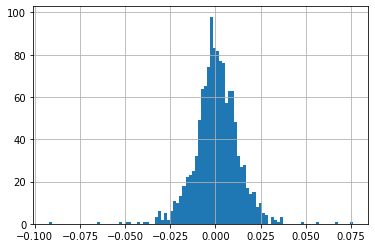

In [10]:
sbux["return"].hist(bins=100);

In [11]:
sbux["return"].mean(), sbux["return"].std()

(0.0006002332205830914, 0.012360934026133879)

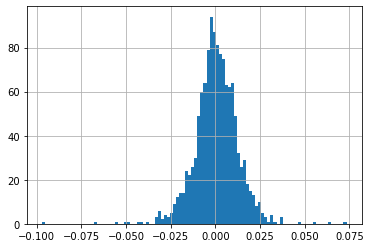

In [12]:
sbux["log_return"].hist(bins=100);

In [13]:
sbux["log_return"].mean(), sbux["log_return"].std()

(0.0005235902748108682, 0.012381234216101258)

### QQ plots

In [14]:
x_list = np.linspace(
    sbux['return'].min(),
    sbux['return'].max(),
    100
)

In [15]:
y_list = norm.pdf(x_list, loc=sbux['return'].mean(), scale=sbux['return'].std())

<AxesSubplot:>

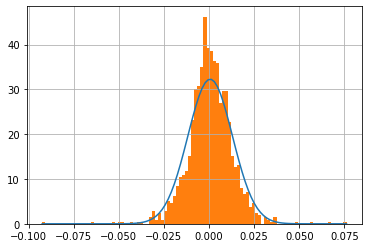

In [16]:
plt.plot(x_list, y_list);
sbux['return'].hist(bins=100, density=True)

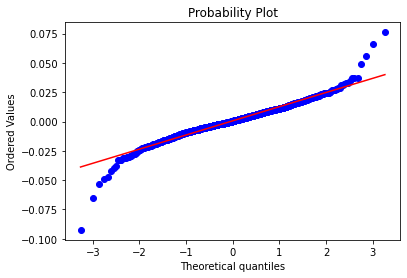

In [17]:
probplot(sbux['return'].dropna(), dist='norm', fit=True, plot=plt);

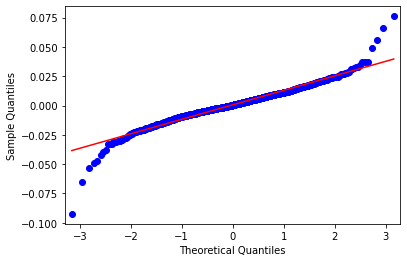

In [18]:
sm.qqplot(sbux['return'].dropna(), line='s');

In [19]:
x_list_log = np.linspace(
    sbux['log_return'].min(),
    sbux['log_return'].max(),
    100
)

In [20]:
y_list_log = norm.pdf(x_list_log, loc=sbux['log_return'].mean(), scale=sbux['log_return'].std())

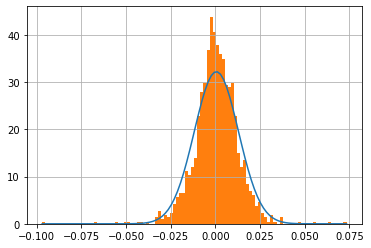

In [21]:
plt.plot(x_list_log, y_list_log);
sbux['log_return'].hist(bins=100, density=True);

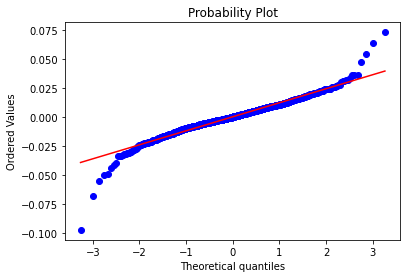

In [22]:
probplot(sbux['log_return'].dropna(), dist='norm', fit=True, plot=plt);

### t-distribution

In [23]:
params = t.fit(sbux['return'].dropna())

In [24]:
params

(4.78753221828017, 0.0007108616716254146, 0.009341981642040986)

In [25]:
df, loc, scale = params

In [26]:
y_list = t.pdf(x_list, df, loc, scale)

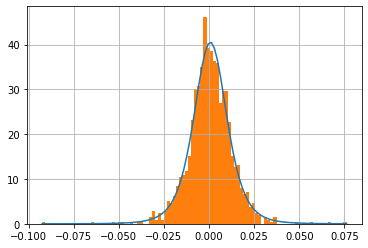

In [27]:
plt.plot(x_list, y_list);
sbux['return'].hist(bins=100,density=True);

In [28]:
# sm.qqplot(sbux['return'].dropna(), dist=t,line='s');

In [29]:
# probplot(sbux['log_return'].dropna(), dist='t', fit=True, plot=plt);

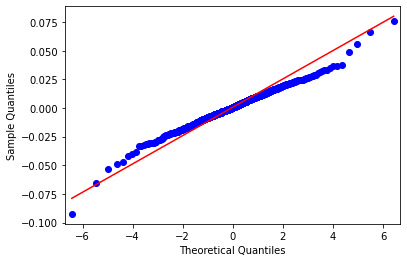

In [30]:
sm.qqplot(sbux['return'].dropna(), dist=myt(df),line='s');

In [31]:
params_log = t.fit(sbux['log_return'].dropna())

In [32]:
df_log, loc_log, scale_log = params_log

In [33]:
y_list_log = t.pdf(x_list_log, df_log, loc_log, scale_log)

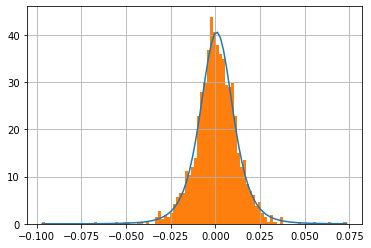

In [34]:
plt.plot(x_list_log, y_list_log);
sbux['log_return'].hist(bins=100,density=True);

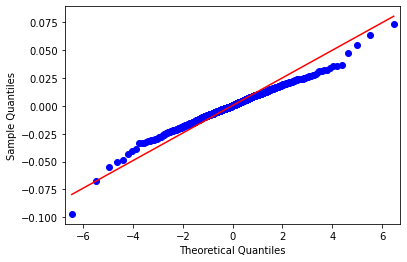

In [35]:
sm.qqplot(sbux['log_return'].dropna(), dist=myt(df_log),line='s');

### Skewness and Kurtosis

In [36]:
sbux['return'].skew()

-0.2680784195824153

In [37]:
sbux['return'].kurtosis()

5.593158903424731

In [38]:
sbux['log_return'].skew()

-0.41015501490182066

In [39]:
sbux['log_return'].kurtosis()

5.964502225799283

### Sample

In [40]:
sample = pd.Series(np.random.randn(10000))
sample.skew(), sample.kurtosis()

(-0.03646204849411268, 0.015480472685445168)

In [41]:
# these are all excess skewness and kurtosis

### Confidence Interval

In [43]:
values = sbux['return'].dropna().to_numpy()

In [44]:
m = values.mean()
s = values.std(ddof=1)

In [49]:
low   = m - 1.96 * s / np.sqrt(len(values))
high = m + 1.96 * s / np.sqrt(len(values))

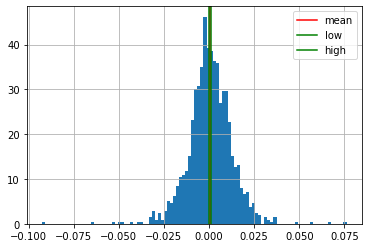

In [50]:
sbux['return'].hist(bins=100, density=True)
plt.axvline(m, label='mean', color='red')
plt.axvline(low, label='low', color='green')
plt.axvline(high, label='high', color='green')
plt.legend();

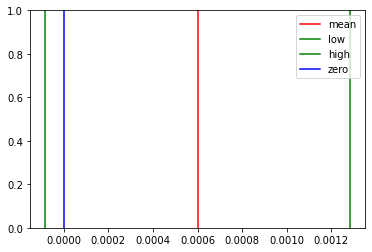

In [54]:
plt.axvline(m, label='mean', color='red')
plt.axvline(low, label='low', color='green')
plt.axvline(high, label='high', color='green')
plt.axvline(0, label='zero', color='blue')
plt.legend();